# Assignment 2

Deadline: 26.03.2025, 12:00 CET

<Add your name, student-id and emal address>
* Zihan Liu, 22-736-938, zihan.liu@uzh.ch
* Yujie Tao, 23-744-378, yujie.tao@uzh.ch
* Weijie Chen, 23-743-727, weijie.chen@uzh.ch
* Schmidli Adrian, 17-728-833, adrian.schmidli@uzh.ch

## 1. Linearization of Turnover

**(15 points)**

Turnover constraints are used to limit the amount of change in portfolio weights between periods, helping to manage transaction costs and maintain portfolio stability.

Your task is to implement a method `linearize_turnover_constraint` for the class `QuadraticProgram`, which modifies the quadratic programming problem to incorporate a linearized turnover constraint. This will involve updating the objective function coefficients, equality and inequality constraints, as well as the lower and upper bounds of the problem. 

Additionally, complete the example provided below to demonstrate that your method functions correctly.

In class, we discussed a solution that involved augmenting the dimensionality by a factor of three. Here, you are asked to implement an alternative method that involves a two-fold increase in dimensions. If you are unable to implement the two-fold method, you may proceed with the three-fold approach.

### Function Parameters:
- `x_init` (np.ndarray): The initial portfolio weights.
- `to_budget` (float, optional): The maximum allowable turnover. Defaults to `float('inf')`.

### Steps for Function Implementation:

As discussed in the lecture, introduce auxiliary variables and augment the matrices/vectors used for optimization.

- **Objective Function Coefficients**:  
  Pad the existing objective function coefficients (`P` and `q`) to accommodate the new variables introduced by the turnover constraint.  
  *Note*: "Padding" refers to adding extra elements (typically zeros) to an array or matrix to increase its size to a desired shape.

- **Equality Constraints**:  
  Pad the existing equality constraint matrix (`A`) to account for the new variables.

- **Inequality Constraints**:  
  Pad the existing inequality constraint matrix (`G`) and vector (`h`) and further add a new inequality constraint row to incorporate the turnover constraint.  

- **Lower and Upper Bounds**:  
  Pad the existing lower (`lb`) and upper (`ub`) bounds to accommodate the new variables.

- **Update Problem Data**:  
  Overwrite the original problem data in the `QuadraticProgram` class with the updated matrices and vectors to include the linearized turnover constraint.

In [29]:
# Import standard libraries
import types
import os
import sys

# Import third-party libraries
import numpy as np
import pandas as pd

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))  # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.quadratic_program import QuadraticProgram
from helper_functions import load_data_msci

In [69]:
def linearize_turnover_constraint(self, x_init: np.ndarray, to_budget=float('inf')) -> None:
        '''
        Linearize the turnover constraint in the quadratic programming problem.

        This method modifies the quadratic programming problem to include a linearized turnover constraint.

        Parameters:
        -----------
        x_init : np.ndarray
            The initial portfolio weights.
        to_budget : float, optional
            The maximum allowable turnover. Defaults to float('inf').

        Notes:
        ------
        - The self parameter in Python is used in object-oriented programming (OOP). It refers to the instance of the class where the method is being defined (here the class "QuadraticProgram").
        - None: The function doesn't return anything.
        - The method updates the problem's objective function coefficients, inequality constraints,
        equality constraints, and bounds to account for the turnover constraint.
        - The original problem data is overridden with the updated matrices and vectors.

        Examples:
        ---------
        >>> qp = QuadraticProgram(P, q, G, h, A, b, lb, ub, solver='cvxopt')
        >>> qp.linearize_turnover_constraint(x_init=np.array([0.1, 0.2, 0.3]), to_budget=0.05)
        '''
        P = self.problem_data.get('P')
        q = self.problem_data.get('q')
        A = self.problem_data.get('A')
        b = self.problem_data.get('b')
        G = self.problem_data.get('G')
        h = self.problem_data.get('h')
        lb = self.problem_data.get('lb')
        ub = self.problem_data.get('ub')
        # Getting the needed data for the linearization of the optimization problem out of the dictionary "problem_data", that is created in the class "QuadraticProgram".
        # You don’t augment x manually because you're not solving the problem yet — you're just setting it up.
        # In optimization solvers, like "CVXOPT", "OSQP", or others, the variable vector x (weights) is implicitly defined by the dimensions of the matrices and vectors (P and q).
       
        # Dimensions
        # self.problem_data is a dictionary that incudes the objective function, the equality constraints etc. (look into the class quadratic_program).
        n = len(q) # get the dimension of q (expected return per column).
        # m = 0 if G is None else G.shape[0] # If there is no matrix G (inequality constraints) then return 0, but if there is a matrix G it returns the number of rows ("shape[0]": each row one constraint).

        # Update the coefficients of the objective function (two-fold approach)
        P_aug = np.pad(P, ((0, n), (0, n)), mode='constant') # Augment P to 2n x 2n by padding zeros ((0,n) -> adding n additional rows, (0,n) -> adding n additional columns). mode = "constant" meaning filling up the additional rows/columns with a constant value (default = 0).
        q_aug = np.pad(q, ((0, n)), mode='constant') # Augment q to 1 x 2n by padding zeros.

        # Update the equality constraints (two-fold approach) 
        if A is not None:
            A_aug = np.pad(A, ((0, 0), (0, n)), mode='constant') # Augment A to 1 x 2n by padding zeros.
        else:
            A_aug = A # Because A is set to "None" in the class "QuadraticProgram", so A_aug has to be also "None".
        
        # Add additional equality constraints (two-fold approach)
        A_add_con_1 = np.zeros(2 * n)
        A_add_con_2 = np.zeros(2 * n)
        A_add_con_3 = np.zeros(2 * n)
        A_add_con_1[n + 0] = 1 # -> add some additional constraints like a net change constraint (z1 + z2 + z3 = 0 if n = 3) 
        A_add_con_1[n + 1] = 1 # -> or that if one asset changes another has to change twice as much (2 * z1 - z2 = 0)
        A_add_con_1[n + 2] = 1 # -> etc.
        # It is only necessary to define the z-values, that are unequal to zero. The others are set to zero automatically.
        
        A_add_con_list = []

        for name, con in locals().items():
            if name.startswith("A_add_con_") and isinstance(con, np.ndarray):
                if not np.all(con == 0):
                    A_add_con_list.append(con)

        A_add_cons = np.vstack(A_add_con_list) if A_add_con_list else None

        if A_add_cons is not None:
            if A_aug is not None:
                A_aug = np.vstack([A_aug, A_add_cons])
            else:
                A_aug = A_add_cons.reshape(len(A_add_cons), -1) 
        
        if A_add_cons is not None:
            b_add_cons = np.zeros(len(A_add_cons))
            b_add_cons[0] = 0.2 # -> can be used if we would like to add a value in the b-vector which is unequal to zero for the additional constraints.
            if b is not None:
                b_aug = np.hstack([b, b_add_cons])
            else:
                b_aug = A_add_cons.reshape(len(A_add_cons), -1)
        else:
            b_aug = b

        # Update the inequality constraints (two-fold approach)
        G_add_con_list = []

        if G is not None:
            G_aug = np.pad(G, ((0, 0), (0, n)), mode='constant')
            for i in range(n):
                row = np.zeros(2 * n)
                row[i] = 1
                row[i + n] = -1
                G_add_con_list.append(row)
                neg_row = row.copy()
                neg_row[i] = -1
                neg_row[i + n] = -1
                G_add_con_list.append(neg_row)
            row_tau = np.hstack([np.zeros(n), np.ones(n)])
            G_aug = np.vstack([G_aug, G_add_con_list, row_tau])
        else:
            for i in range(n):
                row = np.zeros(2 * n)
                row[i] = 1
                row[i + n] = -1
                G_add_con_list.append(row)
                neg_row = row.copy()
                neg_row[i] = -1
                neg_row[i + n] = -1
                G_add_con_list.append(neg_row)
            row_tau = np.hstack([np.zeros(n), np.ones(n)])
            G_aug = np.vstack([G_add_con_list, row_tau])
        
        if h is not None:
            x_init_adj = np.empty((2 * len(x_init),), dtype=float)
            x_init_adj[0::2] = x_init # Start at index 0, go to the end, and take every 2nd element and assign "x_init" to it.
            x_init_adj[1::2] = -x_init # Start at index 1, go to the end, and take every 2nd element and assign "-x_init" to it.
            h_aug = np.hstack([h, x_init_adj, to_budget])
        else:
            x_init_adj = np.empty((2 * len(x_init),), dtype=float)
            x_init_adj[0::2] = x_init
            x_init_adj[1::2] = -x_init
            h_aug = np.hstack([x_init_adj, to_budget])

        # Update lower and upper bounds (two-fold approach)
        if lb is not None:
            lb_aug = np.pad(lb, ((0, n)), mode='constant') # z >= 0 because z is an absolute value.
        else:
            lb_aug = lb # Because lb is set to "None" in the class "QuadraticProgram", so lb_aug has to be also "None".

        if ub is not None:
            ub_aug = np.pad(ub, (0, n), mode='constant', constant_values=np.inf) # z could be infinitely large because the z-value is not predefined in the optimization problem.
            # NumPy is optimized for numerical operations. Using "np.inf" might lead to slightly better performance, especially when dealing with large arrays than using "float('inf')".
        else:
            ub_aug = ub # Because ub is set to "None" in the class "QuadraticProgram", so ub_aug has to be also "None".

        # Override the original matrices (notice: b does not change) -> have a look on my notes!
        self.update_problem_data({
            'P': P_aug,
            'q': q_aug,
            'A': A_aug,
            'b': b_aug,
            'G': G_aug,
            'h': h_aug,
            'lb': lb_aug,
            'ub': ub_aug
        })

        # For debugging
        print("A_aug:\n", A_aug) 
        print("b_aug:\n", b_aug)
        # print("G_aug:\n", G_aug)
        # print("h_aug:\n", h_aug)
        # print("lb_aug:\n", lb_aug)
        # print("ub_aug:\n", ub_aug)

        return None # Does not return any output. Just augment the system and override the initial values.

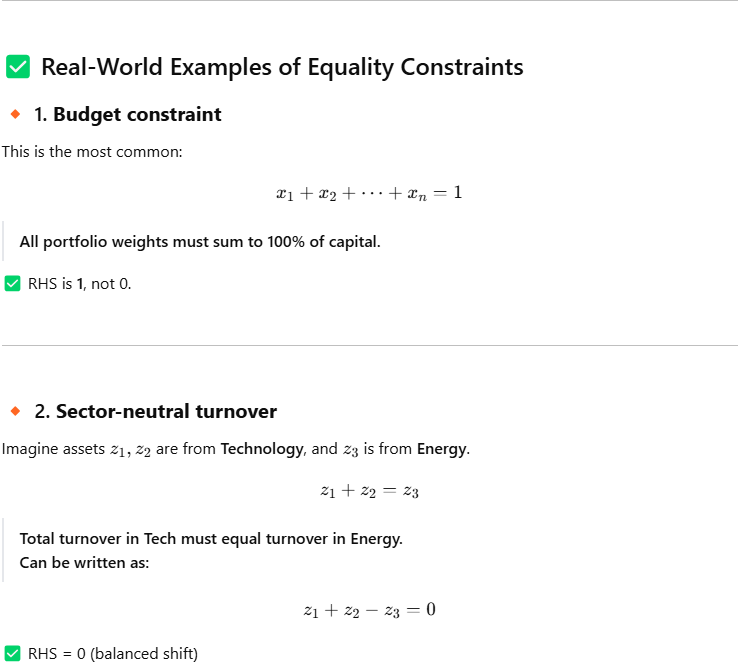
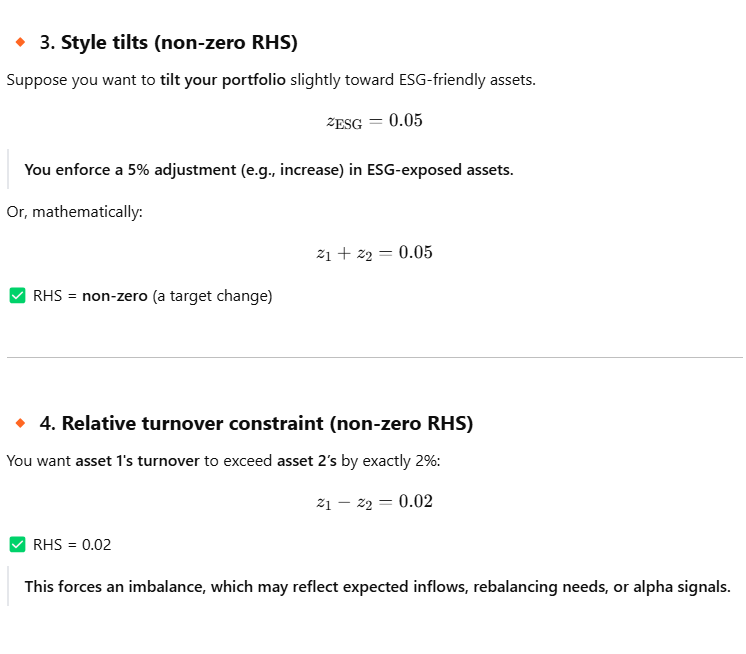
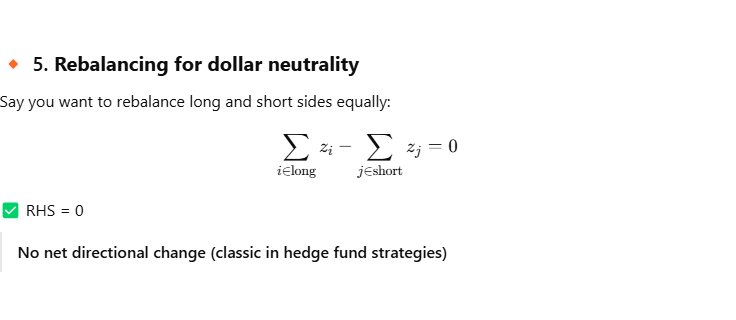

#### Additional explanation about the two-fold approach
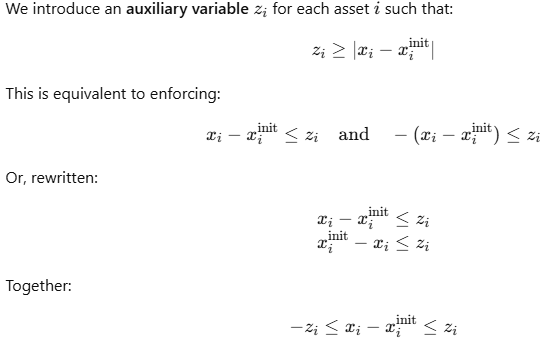
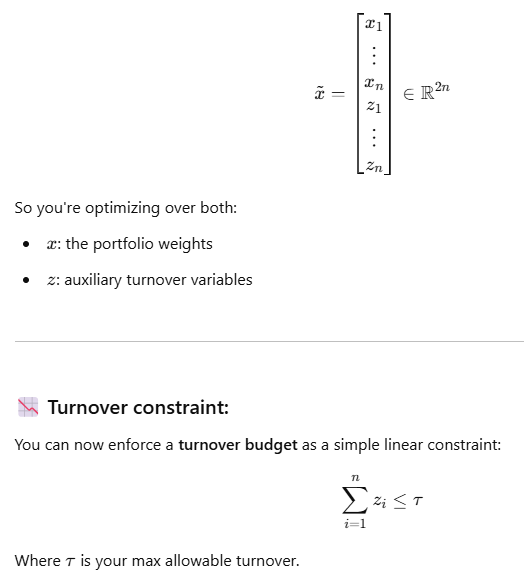
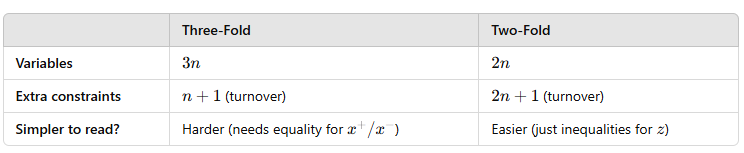

For additional information about the three-fold approach have a look at my notes of lecture 3!

## Demo

#### Create P and q

In [57]:
# Load the msci country index data
N = 10 # Defines how many columns we include (without the date column).
data = load_data_msci(path = '../data/', n = N)
X = data['return_series'] # "load_data_msci" is a function defined in the class "helper_functions" and "return_series" is specified there.
print("Variable X =", X)
# input("Press Enter to continue...")

# Compute the vector of expected returns (mean returns)
q = ExpectedReturn(method='geometric').estimate(X=X, inplace=False) # "ExpectedReturn" is a function defined in the class "expected_return".
print("Variable q =", q)
# input("Press Enter to continue...")

# Compute the covariance matrix
P = Covariance(method='pearson').estimate(X=X, inplace=False) # "Covariance" is a function defined in the class "covariance".
print("Variable P =", P)

# q, P

Variable X =                   AT        AU        BE        CA        CH        DE  \
Index                                                                    
1999-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1999-01-04  0.010057  0.009080  0.042147  0.013070  0.035885  0.052249   
1999-01-05  0.013661 -0.010048  0.020162  0.021940  0.012016  0.001444   
1999-01-06  0.000000  0.015264 -0.000078  0.027640  0.015335  0.036205   
1999-01-07  0.004104  0.016564 -0.016877 -0.003480 -0.011902 -0.020187   
...              ...       ...       ...       ...       ...       ...   
2023-04-12 -0.002488  0.004714 -0.012072  0.001708  0.000017  0.002662   
2023-04-13  0.001297 -0.003806 -0.000049  0.004728  0.000913  0.002400   
2023-04-14  0.009533  0.004829  0.007622  0.001950  0.008387  0.005797   
2023-04-17 -0.005665  0.003404  0.004917  0.003392 -0.001485 -0.002086   
2023-04-18  0.004836 -0.003262 -0.007127  0.002161  0.004373  0.006089   

                  DK    

### Create some constraints, instantiate an object of class QuadraticProgram, and add the method linearize_turnover_constraint to the instance.

In [70]:
# Instantiate the constraints with only the budget and long-only constraints (no inequality constraints)
constraints = Constraints(ids = X.columns.tolist())
constraints.add_budget(rhs=1, sense='=')
constraints.add_box(lower=0.0, upper=1.0)
GhAb = constraints.to_GhAb()

# Create a quadratic program and linearize the turnover constraint
qp = QuadraticProgram(
    P = P.to_numpy(),
    q = q.to_numpy() * 0,
    G = GhAb['G'],
    h = GhAb['h'],
    A = GhAb['A'],
    b = GhAb['b'],
    lb = constraints.box['lower'].to_numpy(),
    ub = constraints.box['upper'].to_numpy(),
    solver = 'cvxopt',
)

# Add the linearized turnover constraint method to the instance of class QuadraticProgram
qp.linearize_turnover_constraint = types.MethodType(linearize_turnover_constraint, qp)


### Add a turnover limit of 50%. Solve the problem and check whether the turnover constraint is respected.

In [71]:
# Prepare initial weights
x_init = pd.Series([1/X.shape[1]]*X.shape[1], index=X.columns)

# Add the linearized turnover constraint
qp.linearize_turnover_constraint(x_init=x_init, to_budget=0.5)

# Solve the problem
qp.solve()

# Check the turnover
solution = qp.results.get('solution')
ids = constraints.ids
weights = pd.Series(solution.x[:len(ids)], index=ids)

print("Turnover:")
print(np.abs(weights - x_init).sum())

A_aug:
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]
b_aug:
 [1.  0.2]
Turnover:
0.49988953408985215
